# Core

> Lisette Core

In [ ]:
#| default_exp core

In [ ]:
#| hide
from cachy import enable_cachy,disable_cachy

In [ ]:
#| hide
enable_cachy()

In [ ]:
#| export
import asyncio, base64, json, litellm, mimetypes, random, string
from typing import Optional
from html import escape
from IPython.display import Markdown
from litellm import (acompletion, completion, stream_chunk_builder, Message,
                     ModelResponse, ModelResponseStream, get_model_info, register_model, Usage)
from litellm.utils import function_to_dict, StreamingChoices, Delta, ChatCompletionMessageToolCall, Function, Choices
from toolslm.funccall import mk_ns, call_func, call_func_async, get_schema
from fastcore.utils import *
from fastcore import imghdr

In [ ]:
#| hide
from fastcore.test import *
from IPython.display import Image
from fastcore.xtras import SaveReturn
from fastcore.test import *

# LiteLLM

## Deterministic outputs

LiteLLM `ModelResponse(Stream)` objects have `id` and `created_at` fields that are generated dynamically. Even when we use [`cachy`](https://github.com/answerdotai/cachy) to cache the LLM response these dynamic fields create diffs which makes code review more challenging. The patches below ensure that `id` and `created_at` fields are fixed and won't generate diffs.

In [ ]:
#| export
def patch_litellm(seed=0):
    "Patch litellm.ModelResponseBase such that `id` and `created` are fixed."
    from litellm.types.utils import ModelResponseBase
    @patch
    def __init__(self: ModelResponseBase, id=None, created=None, *args, **kwargs): 
        self._orig___init__(id='chatcmpl-xxx', created=1000000000, *args, **kwargs)

    @patch
    def __setattr__(self: ModelResponseBase, name, value):
        if name == 'id': value = 'chatcmpl-xxx'
        elif name == 'created': value = 1000000000
        self._orig___setattr__(name, value)

    if seed is not None: random.seed(seed) # ensures random ids like tool call ids are deterministic

In [ ]:
patch_litellm()

## Completion

LiteLLM provides an convenient unified interface for most big LLM providers. Because it's so useful to be able to switch LLM providers with just one argument. We want to make it even easier to by adding some more convenience functions and classes. 

This is very similar to our other wrapper libraries for popular AI providers: [claudette](https://claudette.answer.ai/) (Anthropic), [gaspard](https://github.com/AnswerDotAI/gaspard) (Gemini), [cosette](https://answerdotai.github.io/cosette/) (OpenAI).

In [ ]:
#| export
@patch
def _repr_markdown_(self: litellm.ModelResponse):
    message = self.choices[0].message
    content = ''
    if mc:=message.content: content += mc[0]['text'] if isinstance(mc,list) else mc
    if message.tool_calls:
        tool_calls = [f"\n\n🔧 {nested_idx(tc,'function','name')}({nested_idx(tc,'function','arguments')})\n" for tc in message.tool_calls]
        content += "\n".join(tool_calls)
    if not content: content = str(message)
    details = [
        f"id: `{self.id}`",
        f"model: `{self.model}`",
        f"finish_reason: `{self.choices[0].finish_reason}`"
    ]
    if hasattr(self, 'usage') and self.usage: details.append(f"usage: `{self.usage}`")
    det_str = '\n- '.join(details)
    
    return f"""{content}

<details>

- {det_str}

</details>"""

In [ ]:
#| export
register_model({
    "claude-sonnet-4-5": {
        "max_tokens": 64000, "max_input_tokens": 200000, "max_output_tokens": 64000,
        "input_cost_per_token": 3e-06, "output_cost_per_token": 1.5e-05, "cache_creation_input_token_cost": 3.75e-06, "cache_read_input_token_cost": 3e-07,
        "litellm_provider": "anthropic", "mode": "chat",
        "supports_function_calling": True, "supports_parallel_function_calling": True, "supports_vision": True, "supports_prompt_caching": True, "supports_response_schema": True, "supports_system_messages": True, "supports_reasoning": True, "supports_assistant_prefill": True,
        "supports_tool_choice": True, "supports_computer_use": True 
    }
});
sonn45 = "claude-sonnet-4-5"

In [ ]:
# litellm._turn_on_debug()

In [ ]:
ms = ["gemini/gemini-2.5-flash", "claude-sonnet-4-5", "openai/gpt-4.1"]
msg = [{'role':'user','content':'Hey there!', 'cache_control': {'type': 'ephemeral'}}]
for m in ms:
    display(Markdown(f'**{m}:**'))
    display(completion(m,msg))

**gemini/gemini-2.5-flash:**

Hey there! How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=153, prompt_tokens=4, total_tokens=157, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=143, rejected_prediction_tokens=None, text_tokens=10), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=4, image_tokens=None))`

</details>

**claude-sonnet-4-5:**

Hello! How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=12, prompt_tokens=10, total_tokens=22, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

**openai/gpt-4.1:**

Hello! How can I help you today? 😊

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=10, prompt_tokens=10, total_tokens=20, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

## Messages formatting

Let's start with making it easier to pass messages into litellm's `completion` function (including images, and pdf files).

In [ ]:
#| export
def _bytes2content(data):
    "Convert bytes to litellm content dict (image or pdf)"
    mtype = 'application/pdf' if data[:4] == b'%PDF' else mimetypes.types_map.get(f'.{imghdr.what(None, h=data)}')
    if not mtype: raise ValueError(f'Data must be image or PDF bytes, got {data[:10]}')
    return {'type': 'image_url', 'image_url': f'data:{mtype};base64,{base64.b64encode(data).decode("utf-8")}'}

In [ ]:
#| export
def _add_cache_control(msg,          # LiteLLM formatted msg
                       ttl=None):    # Cache TTL: '5m' (default) or '1h'
    "cache `msg` with default time-to-live (ttl) of 5minutes ('5m'), but can be set to '1h'."
    if isinstance(msg["content"], str): 
        msg["content"] = [{"type": "text", "text": msg["content"]}]
    cache_control = {"type": "ephemeral"}
    if ttl is not None: cache_control["ttl"] = ttl
    if isinstance(msg["content"], list) and msg["content"]:
        msg["content"][-1]["cache_control"] = cache_control
    return msg

def _has_cache(msg):
    return msg["content"] and isinstance(msg["content"], list) and ('cache_control' in msg["content"][-1])

def remove_cache_ckpts(msg):
    "remove cache checkpoints and return msg."
    if _has_cache(msg): msg["content"][-1].pop('cache_control', None)
    return msg

def _mk_content(o):
    if isinstance(o, str): return {'type':'text','text':o.strip() or '.'}
    elif isinstance(o,bytes): return _bytes2content(o)
    return o

In [ ]:
#| export
def mk_msg(
    content,      # Content: str, bytes (image), list of mixed content, or dict w 'role' and 'content' fields
    role="user",  # Message role if content isn't already a dict/Message
    cache=False,  # Enable Anthropic caching
    ttl=None      # Cache TTL: '5m' (default) or '1h'
):
    "Create a LiteLLM compatible message."
    if isinstance(content, dict) or isinstance(content, Message): return content
    if isinstance(content, ModelResponse): return content.choices[0].message
    if isinstance(content, list) and len(content) == 1 and isinstance(content[0], str): c = content[0]
    elif isinstance(content, list): c = [_mk_content(o) for o in content]
    else: c = content
    msg = {"role": role, "content": c}
    return _add_cache_control(msg, ttl=ttl) if cache else msg

Now we can use mk_msg to create different types of messages.

Simple text:

In [ ]:
msg = mk_msg("hey")
msg

{'role': 'user', 'content': 'hey'}

Which can be passed to litellm's `completion` function like this:

In [ ]:
model = ms[1]

In [ ]:
res = completion(model, [msg])
res

Hey! How's it going? What's on your mind?

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=16, prompt_tokens=8, total_tokens=24, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

We'll add a little shortcut to make examples and testing easier here:

In [ ]:
def c(msgs, **kw):
    msgs = [msgs] if isinstance(msgs,dict) else listify(msgs)
    return completion(model, msgs, **kw)

In [ ]:
c(msg)

Hey! How's it going? What's on your mind?

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=16, prompt_tokens=8, total_tokens=24, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

Lists w just one string element are flattened for conciseness:

In [ ]:
test_eq(mk_msg("hey"), mk_msg(["hey"]))

(LiteLLM ignores these fields when sent to other providers)

Text and images:

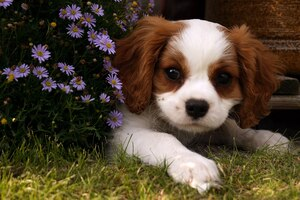

In [ ]:
img_fn = Path('samples/puppy.jpg')
Image(filename=img_fn, width=200)

In [ ]:
msg = mk_msg(['hey what in this image?',img_fn.read_bytes()])
print(json.dumps(msg,indent=1)[:200]+"...")

{
 "role": "user",
 "content": [
  {
   "type": "text",
   "text": "hey what in this image?"
  },
  {
   "type": "image_url",
   "image_url": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/4gxUSU...


In [ ]:
c(msg)

This image shows an adorable **Cavalier King Charles Spaniel puppy**! The puppy has the breed's characteristic features:

- **Coloring**: Brown (chestnut) and white coat
- **Sweet expression**: Large, dark eyes and a gentle face
- **Setting**: The puppy is lying on grass near some purple flowers (appear to be asters or similar blooms)

The puppy looks very young and has that irresistibly cute, innocent look that Cavalier puppies are famous for. The photo has a professional quality with nice lighting and composition, capturing the puppy's endearing personality perfectly!

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=139, prompt_tokens=104, total_tokens=243, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

Let's also demonstrate this for PDFs

In [ ]:
pdf_fn = Path('samples/solveit.pdf')
msg = mk_msg(['Who is the author of this pdf?', pdf_fn.read_bytes()])
c(msg)

The author of this PDF is **Jeremy Howard** from fast.ai. He explicitly introduces himself in the document with "Hi, I'm Jeremy Howard, from fast.ai" and goes on to describe his work co-founding fast.ai with Rachel Thomas eight years ago.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=59, prompt_tokens=1610, total_tokens=1669, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

### Caching

Some providers such as Anthropic require manually opting into caching. Let's try it:

In [ ]:
def cpr(i):
    return f'{i} '*1024 + 'This is a caching test. Report back only what number you see repeated above.'

In [ ]:
#| eval: false
disable_cachy()

In [ ]:
msg = mk_msg(cpr(1), cache=True)
res = c(msg)
res

1

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=5, prompt_tokens=2073, total_tokens=2078, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=2070, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=2070)`

</details>

Anthropic has a maximum of 4 cache checkpoints, so we remove previous ones as we go:

In [ ]:
res = c([remove_cache_ckpts(msg), mk_msg(res), mk_msg(cpr(2), cache=True)])
res

2

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=5, prompt_tokens=4147, total_tokens=4152, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=4144, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=4144)`

</details>

We see that the first message was cached, and this extra message has been written to cache:

In [ ]:
res.usage.prompt_tokens_details

PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=4144, text_tokens=None, image_tokens=None)

We can add a bunch of large messages in a loop to see how the number of cached tokens used grows:

In [ ]:
# #| eval: false
# h = []
# msg = mk_msg(cpr(1), cache=True)
# 
# for o in range(2,25):
#     h += [remove_cache_ckpts(msg), mk_msg(res)]
#     msg = mk_msg(cpr(o), cache=True)
#     res = c(h+[msg])
#     detls = res.usage.prompt_tokens_details
#     print(o, detls.cached_tokens, detls.cache_creation_tokens, end='; ')

In [ ]:
enable_cachy()

### Reconstructing formatted outputs

Lisette can call multiple tools in a loop. Further down this notebook, we'll provide convenience functions for formatting such a sequence of toolcalls and responses into one formatted output string.

For now, we'll show an example and show how to transform such a formatted output string back into a valid LiteLLM history.

In [ ]:
fmt_outp = '''
I'll solve this step-by-step, using parallel calls where possible.

<details class='tool-usage-details'>

```json
{
  "id": "toolu_01KjnQH2Nsz2viQ7XYpLW3Ta",
  "call": { "function": "simple_add", "arguments": { "a": 10, "b": 5 } },
  "result": "15"
}
```

</details>

<details class='tool-usage-details'>

```json
{
  "id": "toolu_01Koi2EZrGZsBbnQ13wuuvzY",
  "call": { "function": "simple_add", "arguments": { "a": 2, "b": 1 } },
  "result": "3"
}
```

</details>

Now I need to multiply 15 * 3 before I can do the final division:

<details class='tool-usage-details'>

```json
{
  "id": "toolu_0141NRaWUjmGtwxZjWkyiq6C",
  "call": { "function": "multiply", "arguments": { "a": 15, "b": 3 } },
  "result": "45"
}
```

</details>
'''

In [ ]:
#| export
detls_tag = "<details class='tool-usage-details'>"
re_tools = re.compile(fr"^({detls_tag}\n+```json\n+(.*?)\n+```\n+</details>)", flags=re.DOTALL|re.MULTILINE)

We can split into chunks of (text,toolstr,json):

In [ ]:
sp = re_tools.split(fmt_outp)
for o in list(chunked(sp, 3, pad=True)): print('- ', o)

-  ["\nI'll solve this step-by-step, using parallel calls where possible.\n\n", '<details class=\'tool-usage-details\'>\n\n```json\n{\n  "id": "toolu_01KjnQH2Nsz2viQ7XYpLW3Ta",\n  "call": { "function": "simple_add", "arguments": { "a": 10, "b": 5 } },\n  "result": "15"\n}\n```\n\n</details>', '{\n  "id": "toolu_01KjnQH2Nsz2viQ7XYpLW3Ta",\n  "call": { "function": "simple_add", "arguments": { "a": 10, "b": 5 } },\n  "result": "15"\n}']
-  ['\n\n', '<details class=\'tool-usage-details\'>\n\n```json\n{\n  "id": "toolu_01Koi2EZrGZsBbnQ13wuuvzY",\n  "call": { "function": "simple_add", "arguments": { "a": 2, "b": 1 } },\n  "result": "3"\n}\n```\n\n</details>', '{\n  "id": "toolu_01Koi2EZrGZsBbnQ13wuuvzY",\n  "call": { "function": "simple_add", "arguments": { "a": 2, "b": 1 } },\n  "result": "3"\n}']
-  ['\n\nNow I need to multiply 15 * 3 before I can do the final division:\n\n', '<details class=\'tool-usage-details\'>\n\n```json\n{\n  "id": "toolu_0141NRaWUjmGtwxZjWkyiq6C",\n  "call": { "func

In [ ]:
#| export
def _extract_tool(text:str)->tuple[dict,dict]:
    "Extract tool call and results from <details> block"
    d = json.loads(text.strip())
    call = d['call']
    func = call['function']
    tc = ChatCompletionMessageToolCall(Function(dumps(call['arguments']),func), d['id'])
    tr = {'role': 'tool','tool_call_id': d['id'],'name': func, 'content': d['result']}
    return tc,tr

def fmt2hist(outp:str)->list:
    "Transform a formatted output into a LiteLLM compatible history"
    lm,hist = Message(),[]
    spt = re_tools.split(outp)
    for txt,_,tooljson in chunked(spt, 3, pad=True):
        txt = txt.strip() if tooljson or txt.strip() else '.'
        hist.append(lm:=Message(txt))
        if tooljson:
            tcr = _extract_tool(tooljson)
            if not hist: hist.append(lm) # if LLM calls a tool without talking
            lm.tool_calls = lm.tool_calls+[tcr[0]] if lm.tool_calls else [tcr[0]] 
            hist.append(tcr[1])
    return hist

See how we can turn that one formatted output string back into a list of Messages:

In [ ]:
from pprint import pprint

In [ ]:
h = fmt2hist(fmt_outp)
pprint(h)

[Message(content="I'll solve this step-by-step, using parallel calls where possible.", role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a":10,"b":5}', name='simple_add'), id='toolu_01KjnQH2Nsz2viQ7XYpLW3Ta', type='function')], function_call=None, provider_specific_fields=None),
 {'content': '15',
  'name': 'simple_add',
  'role': 'tool',
  'tool_call_id': 'toolu_01KjnQH2Nsz2viQ7XYpLW3Ta'},
 Message(content='', role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a":2,"b":1}', name='simple_add'), id='toolu_01Koi2EZrGZsBbnQ13wuuvzY', type='function')], function_call=None, provider_specific_fields=None),
 {'content': '3',
  'name': 'simple_add',
  'role': 'tool',
  'tool_call_id': 'toolu_01Koi2EZrGZsBbnQ13wuuvzY'},
 Message(content='Now I need to multiply 15 * 3 before I can do the final division:', role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a":15,"b":3}', name='

### `mk_msgs`

We will skip tool use blocks and tool results during caching

In [ ]:
#| export
def _skip_tools_cache(msgs, cache_idxs):
    "Skip tool use blocks and tool results in and shift cache indices"
    res = []
    for idx in cache_idxs:
        while msgs[idx].get('tool_calls', []) or msgs[idx]['role'] == 'tool': idx -= 1
        res.append(idx)
    return res

Now lets make it easy to provide entire conversations:

In [ ]:
#| export
def mk_msgs(
    msgs,                   # List of messages (each: str, bytes, list, or dict w 'role' and 'content' fields)
    cache=False,            # Enable Anthropic caching
    cache_idxs=[-1],        # Cache breakpoint idxs
    ttl=None,               # Cache TTL: '5m' (default) or '1h'
):
    "Create a list of LiteLLM compatible messages."
    if not msgs: return []
    if not isinstance(msgs, list): msgs = [msgs]
    res,role = [],'user'
    msgs = L(msgs).map(lambda m: fmt2hist(m) if detls_tag in m else [m]).concat()
    for m in msgs:
        res.append(msg:=remove_cache_ckpts(mk_msg(m, role=role)))
        role = 'assistant' if msg['role'] in ('user','function', 'tool') else 'user'
    if cache: L(_skip_tools_cache(res, cache_idxs)).map(lambda idx: _add_cache_control(res[idx], ttl))
    return res

In [ ]:
msgs = mk_msgs(['Hey, call some functions!',fmt_outp,'How are you?','I am great!'])
test_eq(_skip_tools_cache(msgs, [0, 1, 2, -4, -3, -2, -1]), [0, 0, 0, -10, -3, -2, -1])

With `mk_msgs` you can easily provide a whole conversation:

In [ ]:
msgs = mk_msgs(['Hey!',"Hi there!","How are you?","I'm doing fine and you?"])
msgs

[{'role': 'user', 'content': 'Hey!'},
 {'role': 'assistant', 'content': 'Hi there!'},
 {'role': 'user', 'content': 'How are you?'},
 {'role': 'assistant', 'content': "I'm doing fine and you?"}]

By defualt the last message will be cached when `cache=True`:

In [ ]:
msgs = mk_msgs(['Hey!',"Hi there!","How are you?","I'm doing fine and you?"], cache=True)
msgs

[{'role': 'user', 'content': 'Hey!'},
 {'role': 'assistant', 'content': 'Hi there!'},
 {'role': 'user', 'content': 'How are you?'},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': "I'm doing fine and you?",
    'cache_control': {'type': 'ephemeral'}}]}]

In [ ]:
test_eq('cache_control' in msgs[-1]['content'][0], True)

Alternatively, users can provide custom `cache_idxs`. Tool call blocks and results are will be skipped during caching:

In [ ]:
msgs = mk_msgs(['Hello!','Hi! How can I help you?','Call some functions!',fmt_outp], cache=True, cache_idxs=[0,-2,-1])
msgs

[{'role': 'user',
  'content': [{'type': 'text',
    'text': 'Hello!',
    'cache_control': {'type': 'ephemeral'}}]},
 {'role': 'assistant', 'content': 'Hi! How can I help you?'},
 {'role': 'user',
  'content': [{'type': 'text',
    'text': 'Call some functions!',
    'cache_control': {'type': 'ephemeral'}}]},
 Message(content="I'll solve this step-by-step, using parallel calls where possible.", role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a":10,"b":5}', name='simple_add'), id='toolu_01KjnQH2Nsz2viQ7XYpLW3Ta', type='function')], function_call=None, provider_specific_fields=None),
 {'role': 'tool',
  'tool_call_id': 'toolu_01KjnQH2Nsz2viQ7XYpLW3Ta',
  'name': 'simple_add',
  'content': '15'},
 Message(content='', role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a":2,"b":1}', name='simple_add'), id='toolu_01Koi2EZrGZsBbnQ13wuuvzY', type='function')], function_call=None, provider_specific_fields=None),

In [ ]:
test_eq('cache_control' in msgs[0]['content'][0], True)
test_eq('cache_control' in msgs[2]['content'][0], True) # shifted idxs to skip tools
test_eq('cache_control' in msgs[-1]['content'][0], True)

Who's speaking at when is automatically inferred.
Even when there are multiple tools being called in parallel (which LiteLLM supports!).

In [ ]:
msgs = mk_msgs(['Tell me the weather in Paris and Rome',
                'Assistant calls weather tool two times',
                {'role':'tool','content':'Weather in Paris is ...'},
                {'role':'tool','content':'Weather in Rome is ...'},
                'Assistant returns weather',
                'Thanks!'])
msgs

[{'role': 'user', 'content': 'Tell me the weather in Paris and Rome'},
 {'role': 'assistant', 'content': 'Assistant calls weather tool two times'},
 {'role': 'tool', 'content': 'Weather in Paris is ...'},
 {'role': 'tool', 'content': 'Weather in Rome is ...'},
 {'role': 'assistant', 'content': 'Assistant returns weather'},
 {'role': 'user', 'content': 'Thanks!'}]

In [ ]:
#| hide
test_eq([m['role'] for m in msgs],['user','assistant','tool','tool','assistant','user'])

For ease of use, if `msgs` is not already in a `list`, it will automatically be wrapped inside one. This way you can pass a single prompt into `mk_msgs` and get back a LiteLLM compatible msg history.

In [ ]:
msgs = mk_msgs("Hey")
msgs

[{'role': 'user', 'content': 'Hey'}]

In [ ]:
#| hide
msgs = mk_msgs({'role':'tool','content':'fake tool result'})
msgs

[{'role': 'tool', 'content': 'fake tool result'}]

In [ ]:
msgs = mk_msgs(['Hey!',"Hi there!","How are you?","I'm fine, you?"])
msgs

[{'role': 'user', 'content': 'Hey!'},
 {'role': 'assistant', 'content': 'Hi there!'},
 {'role': 'user', 'content': 'How are you?'},
 {'role': 'assistant', 'content': "I'm fine, you?"}]

However, beware that if you use `mk_msgs` for a single message, consisting of multiple parts.
Then you should be explicit, and make sure to wrap those multiple messages in two lists:

1. One list to show that they belong together in one message (the inner list).
2. Another, because mk_msgs expects a list of multiple messages (the outer list).

This is common when working with images for example:

In [ ]:
msgs = mk_msgs([['Whats in this img?',img_fn.read_bytes()]])
print(json.dumps(msgs,indent=1)[:200]+"...")

[
 {
  "role": "user",
  "content": [
   {
    "type": "text",
    "text": "Whats in this img?"
   },
   {
    "type": "image_url",
    "image_url": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD...


## Streaming

LiteLLM supports streaming responses. That's really useful if you want to show intermediate results, instead of having to wait until the whole response is finished.

We create this helper function that returns the entire response at the end of the stream. This is useful when you want to store the whole response somewhere after having displayed the intermediate results.

In [ ]:
#| export
def stream_with_complete(gen, postproc=noop):
    "Extend streaming response chunks with the complete response"
    chunks = []
    for chunk in gen:
        chunks.append(chunk)
        yield chunk
    postproc(chunks)
    return stream_chunk_builder(chunks)

In [ ]:
r = c(mk_msgs("Hey!"), stream=True)
r2 = SaveReturn(stream_with_complete(r))

In [ ]:
for o in r2:
    cts = o.choices[0].delta.content
    if cts: print(cts, end='')

Hey! How's it going? 😊 What can I help you with today?

In [ ]:
r2.value

Hey! How's it going? 😊 What can I help you with today?

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=22, prompt_tokens=9, total_tokens=31, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=None)`

</details>

## Tools

In [ ]:
#| export
def lite_mk_func(f):
    if isinstance(f, dict): return f
    return {'type':'function', 'function':get_schema(f, pname='parameters')}

In [ ]:
def simple_add(
    a: int,   # first operand
    b: int=0  # second operand
) -> int:
    "Add two numbers together"
    return a + b

In [ ]:
toolsc = lite_mk_func(simple_add)
toolsc

{'type': 'function',
 'function': {'name': 'simple_add',
  'description': 'Add two numbers together\n\nReturns:\n- type: integer',
  'parameters': {'type': 'object',
   'properties': {'a': {'type': 'integer', 'description': 'first operand'},
    'b': {'type': 'integer', 'description': 'second operand', 'default': 0}},
   'required': ['a']}}}

In [ ]:
tmsg = mk_msg("What is 5478954793+547982745? How about 5479749754+9875438979? Always use tools for calculations, and describe what you'll do before using a tool. Where multiple tool calls are required, do them in a single response where possible. ")
r = c(tmsg, tools=[toolsc])

In [ ]:
display(r)

I'll help you calculate both of those sums using the addition tool.

Let me break down what I'll do:
1. First calculation: 5478954793 + 547982745
2. Second calculation: 5479749754 + 9875438979

Since these are independent calculations, I'll perform both at the same time.

🔧 simple_add({"a": 5478954793, "b": 547982745})



🔧 simple_add({"a": 5479749754, "b": 9875438979})


<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=211, prompt_tokens=659, total_tokens=870, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

In [ ]:
#| export
def _lite_call_func(tc,ns,raise_on_err=True):
    try: fargs = json.loads(tc.function.arguments)
    except Exception as e: raise ValueError(f"Failed to parse function arguments: {tc.function.arguments}") from e
    res = call_func(tc.function.name, fargs,ns=ns)
    return {"tool_call_id": tc.id, "role": "tool", "name": tc.function.name, "content": str(res)}

In [ ]:
tcs = [_lite_call_func(o, ns=globals()) for o in r.choices[0].message.tool_calls]
tcs

[{'tool_call_id': 'toolu_01KATe5b5tmd4tK5D9BUZE5S',
  'role': 'tool',
  'name': 'simple_add',
  'content': '6026937538'},
 {'tool_call_id': 'toolu_01E4WQj8RkQj8Z7QLJ6ireTe',
  'role': 'tool',
  'name': 'simple_add',
  'content': '15355188733'}]

In [ ]:
def delta_text(msg):
    "Extract printable content from streaming delta, return None if nothing to print"
    c = msg.choices[0]
    if not c: return c
    if not hasattr(c,'delta'): return None #f'{c}'
    delta = c.delta
    if delta.content: return delta.content
    if delta.tool_calls:
        res = ''.join(f"🔧 {tc.function.name}" for tc in delta.tool_calls if tc.id and tc.function.name)
        if res: return f'\n{res}\n'
    if hasattr(delta,'reasoning_content'): return '🧠' if delta.reasoning_content else '\n\n'
    return None

In [ ]:
r = c(tmsg, stream=True, tools=[toolsc])
r2 = SaveReturn(stream_with_complete(r))
for o in r2: print(delta_text(o) or '', end='')

I'll help you calculate those two sums using the addition tool.

Let me break down what I need to do:
1. Calculate 5478954793 + 547982745
2. Calculate 5479749754 + 9875438979

Since these are independent calculations, I'll perform both additions at once.
🔧 simple_add

🔧 simple_add


In [ ]:
r2.value

I'll help you calculate those two sums using the addition tool.

Let me break down what I need to do:
1. Calculate 5478954793 + 547982745
2. Calculate 5479749754 + 9875438979

Since these are independent calculations, I'll perform both additions at once.

🔧 simple_add({"a": 5478954793, "b": 547982745})



🔧 simple_add({"a": 5479749754, "b": 9875438979})


<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=206, prompt_tokens=659, total_tokens=865, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=None)`

</details>

In [ ]:
msg = mk_msg("Solve this complex math problem: What is the derivative of x^3 + 2x^2 - 5x + 1?")
r = c(msg, stream=True, reasoning_effort="low")
r2 = SaveReturn(stream_with_complete(r))
for o in r2: print(delta_text(o) or '', end='')


🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

🧠🧠🧠🧠🧠🧠🧠🧠

# Derivative Solution

To find the derivative of **f(x) = x³ + 2x² - 5x + 1**, I'll apply the power rule to each term.

## Using the Power Rule: d/dx(xⁿ) = n·xⁿ⁻¹

**Term by term:**
- d/dx(x³) = 3x²
- d/dx(2x²) = 4x
- d/dx(-5x) = -5
- d/dx(1) = 0

## Answer:
**f'(x) = 3x² + 4x - 5**

In [ ]:
r2.value

# Derivative Solution

To find the derivative of **f(x) = x³ + 2x² - 5x + 1**, I'll apply the power rule to each term.

## Using the Power Rule: d/dx(xⁿ) = n·xⁿ⁻¹

**Term by term:**
- d/dx(x³) = 3x²
- d/dx(2x²) = 4x
- d/dx(-5x) = -5
- d/dx(1) = 0

## Answer:
**f'(x) = 3x² + 4x - 5**

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=328, prompt_tokens=66, total_tokens=394, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=148, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=None)`

</details>

## Search

LiteLLM provides search, not via tools, but via the special `web_search_options` param.

**Note:** Not all models support web search. LiteLLM's `supports_web_search` field should indicate this, but it's unreliable for some models like `claude-sonnet-4-20250514`. Checking both `supports_web_search` and `search_context_cost_per_query` provides more accurate detection.

In [ ]:
#| export
def _has_search(m):
    i = get_model_info(m)
    return bool(i.get('search_context_cost_per_query') or i.get('supports_web_search'))

In [ ]:
for m in ms: print(m, _has_search(m))

gemini/gemini-2.5-flash True
claude-sonnet-4-5 True
openai/gpt-4.1 False


When search is supported it can be used like this:

In [ ]:
smsg = mk_msg("Search the web and tell me very briefly about otters")
r = c(smsg, web_search_options={"search_context_size": "low"})  # or 'medium' / 'high'
r

Otters are carnivorous mammals in the subfamily Lutrinae and members of the weasel family. The 14 extant otter species are all semiaquatic, both freshwater and marine. They're found on every continent except Australia and Antarctica.

Otters are distinguished by their long, slim bodies, powerful webbed feet for swimming, and their dense fur, which keeps them warm and buoyant in water. In fact, otters have the densest fur of any animal—as many as a million hairs per square inch in places.

All otters are expert hunters that eat fish, crustaceans, and other critters. They're known for being playful animals and sea otters famously use rocks as tools to crack open shellfish. When it's time to nap, sea otters entangle themselves in kelp so they don't float away.

Many otter species were historically hunted nearly to extinction for their fur but have since recovered in some areas, though several species remain threatened by pollution and habitat loss.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=382, prompt_tokens=18089, total_tokens=18471, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), server_tool_use=ServerToolUse(web_search_requests=1), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

## Citations

Next, lets handle Anthropic's search citations.

When not using streaming, all citations are placed in a separate key in the response:

In [ ]:
r.choices[0].message.provider_specific_fields['citations'][0]

[{'type': 'web_search_result_location',
  'cited_text': 'Otters are carnivorous mammals in the subfamily Lutrinae. ',
  'url': 'https://en.wikipedia.org/wiki/Otter',
  'title': 'Otter - Wikipedia',
  'encrypted_index': 'Eo8BCioICBgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDMlacTT8THSDML7nuhoMyB3Xp2StEfWJOx72IjATEIYmZbwZDH+a0KRLuOHQx4nipGzmvy//B4ItZEaDN4t55aF0a+SnmlUY390IN18qE+y/CtqixJ/kgvGL2GCYkFhQRxMYBA=='}]

However, when streaming the results are not captured this way.
Instead, we provide this helper function that adds the citation to the `content` field in markdown format:

In [ ]:
#| export
def cite_footnote(msg):
    if not (delta:=nested_idx(msg, 'choices', 0, 'delta')): return
    if citation:= nested_idx(delta, 'provider_specific_fields', 'citation'):
        title = citation['title'].replace('"', '\\"')
        delta.content = f'[*]({citation["url"]} "{title}") '
        
def cite_footnotes(stream_list):
    "Add markdown footnote citations to stream deltas"
    for msg in stream_list: cite_footnote(msg)

In [ ]:
r = list(c(smsg, stream=True, web_search_options={"search_context_size": "low"}))
cite_footnotes(r)
stream_chunk_builder(r)

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from the small-clawed otter to the giant otter.

These aquatic mammals are known for [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") their short ears and noses, elongated bodies, long tails, and soft, dense fur. In fact, [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") otters have the densest fur of any animal—as many as a million hairs per square inch, which keeps them warm in water since they lack blubber.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") All otters are expert hunters that eat fish, crustaceans, and other critters. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Sea otters will float on their backs, place a rock on their chests, then smash mollusks down on it until they break open. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") River otters are especially playful, gamboling on land and splashing into rivers and streams. They're highly adapted for water with webbed feet, and [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") can stay submerged for more than 5 minutes, with river otters able to hold their breath for up to 8 minutes.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=431, prompt_tokens=15055, total_tokens=15486, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=None)`

</details>

# Chat

LiteLLM is pretty bare bones. It doesnt keep track of conversation history or what tools have been added in the conversation so far.

So lets make a Claudette style wrapper so we can do streaming, toolcalling, and toolloops without problems.

In [ ]:
#| export
effort = AttrDict({o[0]:o for o in ('low','medium','high')})

In [ ]:
#| export
def _mk_prefill(pf): return ModelResponseStream([StreamingChoices(delta=Delta(content=pf,role='assistant'))])

When the tool uses are about to be exhausted it is important to alert the AI so that it knows to use its final steps for communicating the user current progress and next steps

In [ ]:
#| export
_final_prompt = "You have no more tool uses. Please summarize your findings. If you did not complete your goal please tell the user what further work needs to be done so they can choose how best to proceed."

In [ ]:
#| export
class Chat:
    def __init__(
        self,
        model:str,                # LiteLLM compatible model name 
        sp='',                    # System prompt
        temp=0,                   # Temperature
        search=False,             # Search (l,m,h), if model supports it
        tools:list=None,          # Add tools
        hist:list=None,           # Chat history
        ns:Optional[dict]=None,   # Custom namespace for tool calling 
        cache=False,              # Anthropic prompt caching
        cache_idxs:list=[-1],     # Anthropic cache breakpoint idxs excl. sys prompt incl. final prompt
        ttl=None,                 # Anthropic prompt caching ttl
    ):
        "LiteLLM chat client."
        self.model = model
        hist,tools = mk_msgs(hist,cache,cache_idxs,ttl),listify(tools)
        if ns is None and tools: ns = mk_ns(tools)
        elif ns is None: ns = globals()
        self.tool_schemas = [lite_mk_func(t) for t in tools] if tools else None
        store_attr()
    
    def _prep_msg(self, msg=None, prefill=None):
        "Prepare the messages list for the API call"
        sp = [{"role": "system", "content": self.sp}] if self.sp else []
        if msg: self.hist = mk_msgs(self.hist+[msg], self.cache, self.cache_idxs, self.ttl)
        pf = [{"role":"assistant","content":prefill}] if prefill else []
        return sp + self.hist + pf

    def _call(self, msg=None, prefill=None, temp=None, think=None, search=None, stream=False, max_steps=2, step=1, final_prompt=None, tool_choice=None, **kwargs):
        "Internal method that always yields responses"
        if step>max_steps: return
        if not get_model_info(self.model).get("supports_assistant_prefill"): prefill=None
        if _has_search(self.model) and (s:=ifnone(search,self.search)): kwargs['web_search_options'] = {"search_context_size": effort[s]}
        else: _=kwargs.pop('web_search_options',None)
        res = completion(model=self.model, messages=self._prep_msg(msg, prefill), stream=stream, 
                         tools=self.tool_schemas, reasoning_effort = effort.get(think), tool_choice=tool_choice,
                         # temperature is not supported when reasoning
                         temperature=None if think else ifnone(temp,self.temp),
                         **kwargs)
        if stream:
            if prefill: yield _mk_prefill(prefill)
            res = yield from stream_with_complete(res,postproc=cite_footnotes)
        m = res.choices[0].message
        if prefill: m.content = prefill + m.content
        self.hist.append(m)
        yield res

        if tcs := m.tool_calls:
            tool_results=[_lite_call_func(tc, ns=self.ns) for tc in tcs]
            self.hist+=tool_results
            for r in tool_results: yield r
            if step>=max_steps-1: prompt,tool_choice,search = final_prompt,'none',False
            else: prompt = None
            yield from self._call(
                prompt, prefill, temp, think, search, stream, max_steps, step+1,
                final_prompt, tool_choice, **kwargs)
    
    def __call__(self,
                 msg=None,          # Message str, or list of multiple message parts
                 prefill=None,      # Prefill AI response if model supports it
                 temp=None,         # Override temp set on chat initialization
                 think=None,        # Thinking (l,m,h)
                 search=None,       # Override search set on chat initialization (l,m,h)
                 stream=False,      # Stream results
                 max_steps=2, # Maximum number of tool calls
                 final_prompt=_final_prompt, # Final prompt when tool calls have ran out 
                 return_all=False,  # Returns all intermediate ModelResponses if not streaming and has tool calls
                 **kwargs):
        "Main call method - handles streaming vs non-streaming"
        result_gen = self._call(msg, prefill, temp, think, search, stream, max_steps, 1, final_prompt, **kwargs)     
        if stream: return result_gen              # streaming
        elif return_all: return list(result_gen)  # toolloop behavior
        else: return last(result_gen)             # normal chat behavior

In [ ]:
@patch(as_prop=True)
def cost(self: Chat):
    "Total cost of all responses in conversation history"
    return sum(getattr(r, '_hidden_params', {}).get('response_cost')  or 0
               for r in self.h if hasattr(r, 'choices'))

## Examples

### History tracking

In [ ]:
chat = Chat(model)
res = chat("Hey my name is Rens")
res

Hey Rens! Nice to meet you. How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=20, prompt_tokens=14, total_tokens=34, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

In [ ]:
chat("Whats my name")

Your name is Rens! You told me that when you introduced yourself at the start of our conversation.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=25, prompt_tokens=42, total_tokens=67, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

See now we keep track of history!

History is stored in the `hist` attribute:

In [ ]:
chat.hist

[{'role': 'user', 'content': 'Hey my name is Rens'},
 Message(content='Hey Rens! Nice to meet you. How can I help you today?', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'citations': None, 'thinking_blocks': None}),
 {'role': 'user', 'content': 'Whats my name'},
 Message(content='Your name is Rens! You told me that when you introduced yourself at the start of our conversation.', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'citations': None, 'thinking_blocks': None})]

You can also pass an old chat history into new Chat objects:

In [ ]:
chat2 = Chat(model, hist=chat.hist)
chat2("What was my name again?")

Your name is Rens! You've asked me a couple times now - just checking if I'm paying attention? 😊

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=30, prompt_tokens=76, total_tokens=106, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

### Synthetic History Creation

Lets build chat history step by step. That way we can tweak anything we need to during testing.

In [ ]:
pr = "What is 5 + 7? Use the tool to calculate it."
c = Chat(model, tools=[simple_add])
res = c(pr)

In [ ]:
#| export
@patch
def print_hist(self:Chat):
    "Print each message on a different line"
    for r in self.hist: print(r, end='\n\n')

Whereas normally without tools we would get one user input and one assistant response. Here we get two extra messages in between.
- An assistant message requesting the tools with arguments.
- A tool response with the result to the tool call.

In [ ]:
c.print_hist()

{'role': 'user', 'content': 'What is 5 + 7? Use the tool to calculate it.'}

Message(content=None, role='assistant', tool_calls=[{'index': 0, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_012bi9eSyzhwaG3TgGpytJbc', 'type': 'function'}], function_call=None, provider_specific_fields={'citations': None, 'thinking_blocks': None})

{'tool_call_id': 'toolu_012bi9eSyzhwaG3TgGpytJbc', 'role': 'tool', 'name': 'simple_add', 'content': '12'}

{'role': 'assistant', 'content': 'You have no more tool uses. Please summarize your findings. If you did not complete your goal please tell the user what further work needs to be done so they can choose how best to proceed.'}

Message(content='\n\nThe result of 5 + 7 is **12**.', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'citations': None, 'thinking_blocks': None})



Lets try to build this up manually so we have full control over the inputs.

In [ ]:
#| export
def random_tool_id():
    "Generate a random tool ID with 'toolu_' prefix"
    random_part = ''.join(random.choices(string.ascii_letters + string.digits, k=25))
    return f'toolu_{random_part}'

In [ ]:
random_tool_id()

'toolu_0UAqFzWsDK4FrUMp48Y3tT3QD'

A tool call request can contain one more or more tool calls. Lets make one.

In [ ]:
#| export
def mk_tc(func, args, tcid=None, idx=1):
    if not tcid: tcid = random_tool_id()
    return {'index': idx, 'function': {'arguments': args, 'name': func}, 'id': tcid, 'type': 'function'}

In [ ]:
tc = mk_tc(simple_add.__name__, json.dumps(dict(a=5, b=7)))
tc

{'index': 1,
 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'},
 'id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7',
 'type': 'function'}

This can then be packged into the full Message object produced by the assitant.

In [ ]:
def mk_tc_req(content, tcs): return Message(content=content, role='assistant', tool_calls=tcs, function_call=None)

In [ ]:
tc_cts = "I'll use the simple_add tool to calculate 5 + 7 for you."
tcq = mk_tc_req(tc_cts, [tc])
tcq

Message(content="I'll use the simple_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[ChatCompletionMessageToolCall(index=1, function=Function(arguments='{"a": 5, "b": 7}', name='simple_add'), id='toolu_gAL47D1qXIaSyZPaE1pu1lJo7', type='function')], function_call=None, provider_specific_fields=None)

Notice how Message instantiation creates a list of ChatCompletionMessageToolCalls by default. When the tools are executed this is converted back
to a dictionary, for consistency we want to keep these as dictionaries from the beginning.

In [ ]:
#| export
def mk_tc_req(content, tcs):
    msg = Message(content=content, role='assistant', tool_calls=tcs, function_call=None)
    msg.tool_calls = [{**dict(tc), 'function': dict(tc['function'])} for tc in msg.tool_calls]
    return msg

In [ ]:
tcq = mk_tc_req(tc_cts, [tc])
tcq

Message(content="I'll use the simple_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7', 'type': 'function'}], function_call=None, provider_specific_fields=None)

In [ ]:
c = Chat(model, tools=[simple_add], hist=[pr, tcq])

In [ ]:
c.print_hist()

{'role': 'user', 'content': 'What is 5 + 7? Use the tool to calculate it.'}

Message(content="I'll use the simple_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7', 'type': 'function'}], function_call=None, provider_specific_fields=None)



Looks good so far! Now we will want to provide the actual result!

In [ ]:
#| export
def mk_tc_result(tc, result): return {'tool_call_id': tc['id'], 'role': 'tool', 'name': tc['function']['name'], 'content': result}

Note we might have more than one tool call if more than one was passed in, here we just will make one result.

In [ ]:
tcq.tool_calls[0]

{'index': 1,
 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'},
 'id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7',
 'type': 'function'}

In [ ]:
mk_tc_result(tcq.tool_calls[0], '12')

{'tool_call_id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7',
 'role': 'tool',
 'name': 'simple_add',
 'content': '12'}

In [ ]:
#| export
def mk_tc_results(tcq, results): return [mk_tc_result(a,b) for a,b in zip(tcq.tool_calls, results)]

Same for here tcq.tool_calls will match the number of results passed in the results list.

In [ ]:
tcq

Message(content="I'll use the simple_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7', 'type': 'function'}], function_call=None, provider_specific_fields=None)

In [ ]:
tcr = mk_tc_results(tcq, ['12'])
tcr

[{'tool_call_id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7',
  'role': 'tool',
  'name': 'simple_add',
  'content': '12'}]

Now we can call it with this synthetic data to see what the response is!

In [ ]:
c(tcr[0])

The result of 5 + 7 is **12**.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=17, prompt_tokens=720, total_tokens=737, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

In [ ]:
c.print_hist()

{'role': 'user', 'content': 'What is 5 + 7? Use the tool to calculate it.'}

Message(content="I'll use the simple_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7', 'type': 'function'}], function_call=None, provider_specific_fields=None)

{'tool_call_id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7', 'role': 'tool', 'name': 'simple_add', 'content': '12'}

Message(content='The result of 5 + 7 is **12**.', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'citations': None, 'thinking_blocks': None})



Lets try this again, but lets give it something that is clearly wrong for fun.

In [ ]:
c = Chat(model, tools=[simple_add], hist=[pr, tcq])

In [ ]:
tcr = mk_tc_results(tcq, ['13'])
tcr

[{'tool_call_id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7',
  'role': 'tool',
  'name': 'simple_add',
  'content': '13'}]

In [ ]:
c(tcr[0])

The result of 5 + 7 is **12**.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=17, prompt_tokens=720, total_tokens=737, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

Lets make sure this works with multiple tool calls in the same assistant Message.

In [ ]:
tcs = [
    mk_tc(simple_add.__name__, json.dumps({"a": 5, "b": 7})), 
    mk_tc(simple_add.__name__, json.dumps({"a": 6, "b": 7})), 
]

In [ ]:
tcq = mk_tc_req("I will calculate these for you!", tcs)
tcq

Message(content='I will calculate these for you!', role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_XBetF5gIRHYH7LKBKxJsllLOD', 'type': 'function'}, {'index': 1, 'function': {'arguments': '{"a": 6, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_fU25035HyRrY03K6JBO94XfLE', 'type': 'function'}], function_call=None, provider_specific_fields=None)

In [ ]:
tcr = mk_tc_results(tcq, ['12', '13'])

In [ ]:
c = Chat(model, tools=[simple_add], hist=[pr, tcq, tcr[0]])

In [ ]:
c(tcr[1])

5 + 7 = **12**

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=13, prompt_tokens=812, total_tokens=825, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

In [ ]:
c.print_hist()

{'role': 'user', 'content': 'What is 5 + 7? Use the tool to calculate it.'}

Message(content='I will calculate these for you!', role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_XBetF5gIRHYH7LKBKxJsllLOD', 'type': 'function'}, {'index': 1, 'function': {'arguments': '{"a": 6, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_fU25035HyRrY03K6JBO94XfLE', 'type': 'function'}], function_call=None, provider_specific_fields=None)

{'tool_call_id': 'toolu_XBetF5gIRHYH7LKBKxJsllLOD', 'role': 'tool', 'name': 'simple_add', 'content': '12'}

{'tool_call_id': 'toolu_fU25035HyRrY03K6JBO94XfLE', 'role': 'tool', 'name': 'simple_add', 'content': '13'}

Message(content='5 + 7 = **12**', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'citations': None, 'thinking_blocks': None})



In [ ]:
chat = Chat(ms[1], tools=[simple_add])
res = chat("What's 5 + 3? Use the `simple_add` tool.")
res



The result of 5 + 3 is **8**.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=18, prompt_tokens=742, total_tokens=760, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

In [ ]:
res = chat("Now, tell me a joke based on that result.")
res

Here's a joke based on the number 8:

Why was 6 afraid of 7?

Because 7 8 (ate) 9!

But since we got 8 as our answer, here's another one:

What do you call an 8 that's been working out?

An "ate" with great figure! 💪

(Get it? Because 8 already has a great figure with those curves!)

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=100, prompt_tokens=774, total_tokens=874, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

In [ ]:
chat.hist

[{'role': 'user', 'content': "What's 5 + 3? Use the `simple_add` tool."},
 Message(content=None, role='assistant', tool_calls=[{'index': 0, 'function': {'arguments': '{"a": 5, "b": 3}', 'name': 'simple_add'}, 'id': 'toolu_016dgFwdeaQXSwLPnJzufcWq', 'type': 'function'}], function_call=None, provider_specific_fields={'citations': None, 'thinking_blocks': None}),
 {'tool_call_id': 'toolu_016dgFwdeaQXSwLPnJzufcWq',
  'role': 'tool',
  'name': 'simple_add',
  'content': '8'},
 {'role': 'assistant',
  'content': 'You have no more tool uses. Please summarize your findings. If you did not complete your goal please tell the user what further work needs to be done so they can choose how best to proceed.'},
 Message(content='\n\nThe result of 5 + 3 is **8**.', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'citations': None, 'thinking_blocks': None}),
 {'role': 'user', 'content': 'Now, tell me a joke based on that result.'},
 Message(content='Here\'s a joke based

### Images

In [ ]:
chat = Chat(ms[1])
chat(['Whats in this img?',img_fn.read_bytes()])

# Image Description

This adorable image shows a **Cavalier King Charles Spaniel puppy** with the classic Blenheim coloring (chestnut and white markings). 

## Key features visible:
- **Puppy with expressive brown eyes** looking directly at the camera
- **Soft, fluffy coat** with rich brown/chestnut patches on the ears and around the eyes
- **White blaze** down the center of the face
- **Lying on grass** in what appears to be a garden setting
- **Purple flowers** (possibly asters) visible in the background
- The puppy has a sweet, gentle expression typical of the breed

The photo has a warm, professional quality with nice depth of field that keeps the focus on the puppy's endearing face while softly blurring the floral background.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=188, prompt_tokens=105, total_tokens=293, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

### Prefill

Prefill works as expected:

In [ ]:
chat = Chat(ms[1])
chat("Spell my name",prefill="Your name is R E")

Your name is R E D A C T E D

I don't actually know your name - you haven't told me what it is yet! If you'd like me to spell your name, please let me know what it is first.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=47, prompt_tokens=16, total_tokens=63, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

And the entire message is stored in the history, not just the generated part:

In [ ]:
chat.hist[-1]

Message(content="Your name is R E D A C T E D\n\nI don't actually know your name - you haven't told me what it is yet! If you'd like me to spell your name, please let me know what it is first.", role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'citations': None, 'thinking_blocks': None})

### Streaming

In [ ]:
from time import sleep

In [ ]:
chat = Chat(model)
stream_gen = chat("Count to 5", stream=True)
for chunk in stream_gen:
    if isinstance(chunk, ModelResponse): display(chunk)
    else: print(delta_text(chunk) or '',end='')

1, 2, 3, 4, 5

1, 2, 3, 4, 5

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=17, prompt_tokens=11, total_tokens=28, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=None)`

</details>

Lets try prefill with streaming too:

In [ ]:
stream_gen = chat("Continue counting to 10","Okay! 6, 7",stream=True)
for chunk in stream_gen:
    if isinstance(chunk, ModelResponse): display(chunk)
    else: print(delta_text(chunk) or '',end='')

Okay! 6, 7, 8, 9, 10

Okay! 6, 7, 8, 9, 10

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=12, prompt_tokens=44, total_tokens=56, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=None)`

</details>

### Tool use

Ok now lets test tool use

In [ ]:
for m in ms:
    display(Markdown(f'**{m}:**'))
    chat = Chat(m, tools=[simple_add])
    res = chat("What's 5 + 3? Use the `simple_add` tool. Explain.")
    display(res)

**gemini/gemini-2.5-flash:**


I used the `simple_add` tool with `a=5` and `b=3`. The tool returned `8`.

Therefore, 5 + 3 = 8.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=118, prompt_tokens=159, total_tokens=277, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=79, rejected_prediction_tokens=None, text_tokens=39), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=159, image_tokens=None))`

</details>

**claude-sonnet-4-5:**



**Result: 5 + 3 = 8**

**Explanation:**
The `simple_add` function takes two parameters:
- `a` (first operand): I provided 5
- `b` (second operand): I provided 3

The function added these two numbers together and returned 8, which is the correct sum of 5 and 3.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=89, prompt_tokens=764, total_tokens=853, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

**openai/gpt-4.1:**

The result of 5 + 3 is 8.

Explanation: I used the simple_add tool, which takes two numbers and adds them together. By inputting 5 and 3, the tool calculated the sum as 8.

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=48, prompt_tokens=155, total_tokens=203, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

### Thinking w tool use

In [ ]:
chat = Chat(model, tools=[simple_add])
res = chat("What's 5 + 3?",think='l',return_all=True)
display(*res)



🔧 simple_add({"a": 5, "b": 3})


<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=125, prompt_tokens=638, total_tokens=763, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=43, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_01SY1R38L37vhWpgNgQz2B5h',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}



5 + 3 = **8**

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=14, prompt_tokens=816, total_tokens=830, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

### Search

In [ ]:
chat = Chat(model)
res = chat("Search the web and tell me very briefly about otters", search='l', stream=True)
for o in res:
    if isinstance(o, ModelResponse): sleep(0.01); display(o)
    else: print(delta_text(o) or '',end='')

Otters are charismatic members of the weasel family found on every continent except Australia and Antarctica. There are 13 species in total, including sea otters and river otters.

These aquatic mammals have elongated bodies, long tails, and soft, dense fur. In fact, otters have the densest fur of any animal—as many as a million hairs per square inch. Webbed feet and powerful tails make otters strong swimmers.

All otters are expert hunters that eat fish, crustaceans, and other critters. Sea otters float on their backs, place a rock on their chest, then smash mollusks down on it until it breaks open. They're also known for being playful animals, engaging in activities like sliding into water on natural slides.

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") There are 13 species in total, including sea otters and river otters.

These aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. In fact, [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") otters have the densest fur of any animal—as many as a million hairs per square inch. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Webbed feet and powerful tails make otters strong swimmers.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") All otters are expert hunters that eat fish, crustaceans, and other critters. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Sea otters float on their backs, place a rock on their chest, then smash mollusks down on it until it breaks open. They're also known for being [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") playful animals, engaging in activities like sliding into water on natural slides.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=362, prompt_tokens=15055, total_tokens=15417, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=None)`

</details>

### Multi tool calling

We can let the model call multiple tools in sequence using the `max_steps` parameter.

In [ ]:
chat = Chat(model, tools=[simple_add])
res = chat("What's ((5 + 3)+7)+11? Work step by step", return_all=True, max_steps=5)
for r in res: display(r)

I'll solve this step by step using the addition function.

**Step 1:** First, let me calculate 5 + 3

🔧 simple_add({"a": 5, "b": 3})


<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=100, prompt_tokens=617, total_tokens=717, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_01SykhkA2BGKXm9J56KCkz2B',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

**Step 2:** Now I'll add 7 to that result (8 + 7)

🔧 simple_add({"a": 8, "b": 7})


<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=93, prompt_tokens=730, total_tokens=823, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_013LrGqASqf9Bsk38scV5Pu7',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}

**Step 3:** Finally, I'll add 11 to that result (15 + 11)

🔧 simple_add({"a": 15, "b": 11})


<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=94, prompt_tokens=836, total_tokens=930, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_01RtpzYFxji9ZbQJtTjKwaCi',
 'role': 'tool',
 'name': 'simple_add',
 'content': '26'}

**Answer:** ((5 + 3) + 7) + 11 = **26**

Here's the breakdown:
- 5 + 3 = 8
- 8 + 7 = 15
- 15 + 11 = 26

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=67, prompt_tokens=943, total_tokens=1010, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

Some models support parallel tool calling. I.e. sending multiple tool call requests in one conversation step.

In [ ]:
def multiply(a: int, b: int) -> int:
    "Multiply two numbers"
    return a * b

chat = Chat('openai/gpt-4.1', tools=[simple_add, multiply])
res = chat("Calculate (5 + 3) * (7 + 2)", max_steps=5, return_all=True)
for r in res: display(r)



🔧 simple_add({"a": 5, "b": 3})



🔧 simple_add({"a": 7, "b": 2})


<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=52, prompt_tokens=110, total_tokens=162, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

{'tool_call_id': 'call_qJXSxYvc2ZVHmyIxqQ9OocWM',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

{'tool_call_id': 'call_hCgeAPtd0RhmeADBRWRvY0sG',
 'role': 'tool',
 'name': 'simple_add',
 'content': '9'}



🔧 multiply({"a":8,"b":9})


<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=17, prompt_tokens=178, total_tokens=195, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

{'tool_call_id': 'call_1nwxhn7RXLNl9FcsS8pfn6OZ',
 'role': 'tool',
 'name': 'multiply',
 'content': '72'}

(5 + 3) = 8 and (7 + 2) = 9. Multiplying them gives: 8 × 9 = 72. 

So, (5 + 3) × (7 + 2) = 72.

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=55, prompt_tokens=203, total_tokens=258, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

See it did the additions in one go!

We don't want the model to keep running tools indefinitely. Lets showcase how we can force thee model to stop after our specified number of toolcall rounds:

In [ ]:
def divide(a: int, b: int) -> float:
    "Divide two numbers"
    return a / b

chat = Chat(model, tools=[simple_add, multiply, divide])
res = chat("Calculate ((10 + 5) * 3) / (2 + 1) step by step.", 
           max_steps=3, return_all=True,
           final_prompt="Please wrap-up for now and summarize how far we got.")
for r in res: display(r)

I'll calculate this step by step, following the order of operations.

**Step 1:** Calculate the inner parentheses first
- (10 + 5) = ?
- (2 + 1) = ?

🔧 simple_add({"a": 10, "b": 5})



🔧 simple_add({"a": 2, "b": 1})


<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=173, prompt_tokens=792, total_tokens=965, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_01NZjJc2q4tMJZcS93T1WQHM',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}

{'tool_call_id': 'toolu_013qQVARNY8a6shg4zo2TpNr',
 'role': 'tool',
 'name': 'simple_add',
 'content': '3'}

**Step 2:** Multiply 15 * 3

🔧 multiply({"a": 15, "b": 3})


<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=82, prompt_tokens=1030, total_tokens=1112, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_01Uf17eEfZPHcqFo1C3PYZ5E',
 'role': 'tool',
 'name': 'multiply',
 'content': '45'}



**Step 3:** Divide 45 / 3

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=23, prompt_tokens=1139, total_tokens=1162, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

In [ ]:
#| hide
test_eq(len([o for o in res if isinstance(o,ModelResponse)]),3)

### Tool call exhaustion

In [ ]:
pr = "What is 1+2, and then the result of adding +2, and then +3 to it? Use tools to calculate!"
c = Chat(model, tools=[simple_add])

In [ ]:
res = c(pr, max_steps=2)
res



Let me continue with the next calculation. Now I'll add 2 to the result (3+2):

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=33, prompt_tokens=777, total_tokens=810, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

In [ ]:
assert c.hist[-2]['content'] == _final_prompt

## Async

### AsyncChat

If you want to use LiteLLM in a webapp you probably want to use their async function `acompletion`.
To make that easier we will implement our version of `AsyncChat` to complement it. It follows the same implementation as Chat as much as possible:

In [ ]:
#| export
async def _alite_call_func(tc, ns, raise_on_err=True):
    try: fargs = json.loads(tc.function.arguments)
    except Exception as e: raise ValueError(f"Failed to parse function arguments: {tc.function.arguments}") from e
    res = await call_func_async(tc.function.name, fargs, ns=ns)
    return {"tool_call_id": tc.id, "role": "tool", "name": tc.function.name, "content": str(res)}

In [ ]:
#| export
@asave_iter
async def astream_with_complete(self, agen, postproc=noop):
    chunks = []
    async for chunk in agen:
        chunks.append(chunk)
        postproc(chunk)
        yield chunk
    self.value = stream_chunk_builder(chunks)

In [ ]:
#| export
class AsyncChat(Chat):
    async def _call(self, msg=None, prefill=None, temp=None, think=None, search=None, stream=False, max_steps=2, step=1, final_prompt=None, tool_choice=None, **kwargs):
        if step>max_steps+1: return
        if not get_model_info(self.model).get("supports_assistant_prefill"): prefill=None
        if _has_search(self.model) and (s:=ifnone(search,self.search)): kwargs['web_search_options'] = {"search_context_size": effort[s]}
        else: _=kwargs.pop('web_search_options',None)
        res = await acompletion(model=self.model, messages=self._prep_msg(msg, prefill), stream=stream,
                         tools=self.tool_schemas, reasoning_effort=effort.get(think), tool_choice=tool_choice,
                         # temperature is not supported when reasoning
                         temperature=None if think else ifnone(temp,self.temp), 
                         **kwargs)
        if stream:
            if prefill: yield _mk_prefill(prefill)
            res = astream_with_complete(res,postproc=cite_footnote)
            async for chunk in res: yield chunk
            res = res.value
        m=res.choices[0].message
        if prefill: m.content = prefill + m.content
        yield res
        self.hist.append(m)

        if tcs := m.tool_calls:
            tool_results = []
            for tc in tcs:
                result = await _alite_call_func(tc, ns=self.ns)
                tool_results.append(result)
                yield result
            self.hist+=tool_results
            if step>=max_steps-1: prompt,tool_choice,search = final_prompt,'none',False
            else: prompt = None
            async for result in self._call(
                prompt, prefill, temp, think, search, stream, max_steps, step+1,
                final_prompt, tool_choice=tool_choice, **kwargs):
                    yield result
    
    async def __call__(self,
                       msg=None,          # Message str, or list of multiple message parts
                       prefill=None,      # Prefill AI response if model supports it
                       temp=None,         # Override temp set on chat initialization
                       think=None,        # Thinking (l,m,h)
                       search=None,       # Override search set on chat initialization (l,m,h)
                       stream=False,      # Stream results
                       max_steps=2, # Maximum number of tool calls
                       final_prompt=_final_prompt, # Final prompt when tool calls have ran out 
                       return_all=False,  # Returns all intermediate ModelResponses if not streaming and has tool calls
                       **kwargs):
        result_gen = self._call(msg, prefill, temp, think, search, stream, max_steps, 1, final_prompt, **kwargs)
        if stream or return_all: return result_gen
        async for res in result_gen: pass
        return res # normal chat behavior only return last msg

### Examples

Basic example

In [ ]:
chat = AsyncChat(model)
await chat("What is 2+2?")

2+2 = 4

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=11, prompt_tokens=14, total_tokens=25, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

With tool calls

In [ ]:
async def async_add(a: int, b: int) -> int:
    "Add two numbers asynchronously"
    await asyncio.sleep(0.1)
    return a + b

In [ ]:
chat_with_tools = AsyncChat(model, tools=[async_add])
res = await chat_with_tools("What is 5 + 7? Use the tool to calculate it.", return_all=True)
async for r in res: display(r)



🔧 async_add({"a": 5, "b": 7})


<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=70, prompt_tokens=607, total_tokens=677, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_01NHDNkcpwxW66XRuRFChLxe',
 'role': 'tool',
 'name': 'async_add',
 'content': '12'}



The result of 5 + 7 is **12**.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=18, prompt_tokens=731, total_tokens=749, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

In [ ]:
chat.hist

[{'role': 'user', 'content': 'What is 2+2?'},
 Message(content='2+2 = 4', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'citations': None, 'thinking_blocks': None})]

## Async Streaming Display

This is what our outputs look like with streaming results:

In [ ]:
chat_with_tools = AsyncChat(model, tools=[async_add])
res = await chat_with_tools("What is 5 + 7? Use the tool to calculate it.", stream=True)
async for o in res:
    if isinstance(o,ModelResponseStream): print(delta_text(o) or '',end='')
    elif isinstance(o,dict): print(o)


🔧 async_add
{'tool_call_id': 'toolu_011RxwEK3HSc3VQwwsBZnXnV', 'role': 'tool', 'name': 'async_add', 'content': '12'}


The result of 5 + 7 is **12**.

We use this one quite a bit so we want to provide some utilities to better format these outputs:

In [ ]:
#| export
def _trunc_str(s, mx=2000, replace="<TRUNCATED>"):
    "Truncate `s` to `mx` chars max, adding `replace` if truncated"
    s = str(s).strip()
    return s[:mx]+replace if len(s)>mx else s

Here's a complete `ModelResponse` taken from the response stream:

In [ ]:
resp = ModelResponse(id='chatcmpl-xxx', created=1000000000, model='claude-sonnet-4-5', object='chat.completion', system_fingerprint=None, choices=[Choices(finish_reason='tool_calls', index=0, message=Message(content="I'll calculate ((10 + 5) * 3) / (2 + 1) step by step:", role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 10, "b": 5}', name='simple_add'), id='toolu_018BGyenjiRkDQFU1jWP6qRo', type='function'), ChatCompletionMessageToolCall(function=Function(arguments='{"a": 2, "b": 1}', name='simple_add'), id='toolu_01CWqrNQvoRjf1Q1GLpTUgQR', type='function')], function_call=None, provider_specific_fields=None))], usage=Usage(completion_tokens=228, prompt_tokens=794, total_tokens=1022, prompt_tokens_details=None))
print(repr(resp))

ModelResponse(id='chatcmpl-xxx', created=1000000000, model='claude-sonnet-4-5', object='chat.completion', system_fingerprint=None, choices=[Choices(finish_reason='tool_calls', index=0, message=Message(content="I'll calculate ((10 + 5) * 3) / (2 + 1) step by step:", role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 10, "b": 5}', name='simple_add'), id='toolu_018BGyenjiRkDQFU1jWP6qRo', type='function'), ChatCompletionMessageToolCall(function=Function(arguments='{"a": 2, "b": 1}', name='simple_add'), id='toolu_01CWqrNQvoRjf1Q1GLpTUgQR', type='function')], function_call=None, provider_specific_fields=None))], usage=Usage(completion_tokens=228, prompt_tokens=794, total_tokens=1022, completion_tokens_details=None, prompt_tokens_details=None))


In [ ]:
tc=resp.choices[0].message.tool_calls[0]
tc

ChatCompletionMessageToolCall(function=Function(arguments='{"a": 10, "b": 5}', name='simple_add'), id='toolu_018BGyenjiRkDQFU1jWP6qRo', type='function')

In [ ]:
tr={'tool_call_id': 'toolu_018BGyenjiRkDQFU1jWP6qRo', 'role': 'tool','name': 'simple_add',
    'content': '15 is the answerrrr' +'r'*2000}

In [ ]:
#| export
def mk_tr_details(tr, tc, mx=2000):
    "Create <details> block for tool call as JSON"
    args = {k:_trunc_str(v, mx=mx) for k,v in json.loads(tc.function.arguments).items()}
    res = {'id':tr['tool_call_id'], 
           'call':{'function': tc.function.name, 'arguments': args},
           'result':_trunc_str(tr.get('content'), mx=mx),}
    return f"\n\n{detls_tag}\n\n```json\n{dumps(res, indent=2)}\n```\n\n</details>\n\n"

In [ ]:
mk_tr_details(tr,tc)

'\n\n<details class=\'tool-usage-details\'>\n\n```json\n{\n  "id": "toolu_018BGyenjiRkDQFU1jWP6qRo",\n  "call": {\n    "function": "simple_add",\n    "arguments": {\n      "a": "10",\n      "b": "5"\n    }\n  },\n  "result": "15 is the answerrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr

In [ ]:
#| export
class AsyncStreamFormatter:
    def __init__(self, include_usage=False, mx=2000):
        self.outp,self.tcs,self.include_usage,self.think,self.mx = '',{},include_usage,False,mx
    
    def format_item(self, o):
        "Format a single item from the response stream."
        res = ''
        if isinstance(o, ModelResponseStream):
            d = o.choices[0].delta
            if nested_idx(d, 'reasoning_content'): 
                self.think = True
                res += '🧠'
            elif self.think:
                self.think = False
                res += '\n\n'
            if c:=d.content: res+=c
        elif isinstance(o, ModelResponse):
            if self.include_usage: res += f"\nUsage: {o.usage}"
            if c:=getattr(o.choices[0].message,'tool_calls',None):
                self.tcs = {tc.id:tc for tc in c}
        elif isinstance(o, dict) and 'tool_call_id' in o:
            res += mk_tr_details(o, self.tcs.pop(o['tool_call_id']), mx=self.mx)
        self.outp+=res
        return res
    
    async def format_stream(self, rs):
        "Format the response stream for markdown display."
        async for o in rs: yield self.format_item(o)

In [ ]:
stream_msg = ModelResponseStream([StreamingChoices(delta=Delta(content="Hello world!"))])
print(repr(AsyncStreamFormatter().format_item(stream_msg)))

'Hello world!'


In [ ]:
reasoning_msg = ModelResponseStream([StreamingChoices(delta=Delta(reasoning_content="thinking..."))])
print(repr(AsyncStreamFormatter().format_item(reasoning_msg)))

'🧠'


In [ ]:
mock_tool_call = ChatCompletionMessageToolCall(
    id="toolu_123abc456def", type="function", 
    function=Function( name="simple_add", arguments='{"a": 5, "b": 3}' )
)

mock_response = ModelResponse()
mock_response.choices = [type('Choice', (), {
    'message': type('Message', (), {
        'tool_calls': [mock_tool_call]
    })()
})()]

mock_tool_result = {
    'tool_call_id': 'toolu_123abc456def', 'role': 'tool', 
    'name': 'simple_add', 'content': '8'
}

In [ ]:
fmt = AsyncStreamFormatter()
fmt.format_item(mock_response)
print(fmt.format_item(mock_tool_result))



<details class='tool-usage-details'>

```json
{
  "id": "toolu_123abc456def",
  "call": {
    "function": "simple_add",
    "arguments": {
      "a": "5",
      "b": "3"
    }
  },
  "result": "8"
}
```

</details>




In jupyter it's nice to use this `AsyncStreamFormatter` in combination with the `Markdown` `display`:

In [ ]:
#| export
async def adisplay_stream(rs):
    "Use IPython.display to markdown display the response stream."
    fmt = AsyncStreamFormatter()
    md = ''
    async for o in fmt.format_stream(rs): 
        md+=o
        display(Markdown(md),clear=True)
    return fmt

## Streaming examples

Now we can demonstrate `AsyncChat` with `stream=True`!

### Tool call

In [ ]:
chat = AsyncChat(model, tools=[async_add])
res = await chat("What is 5 + 7? Use the tool to calculate it.", stream=True)
fmt = await adisplay_stream(res)



<details class='tool-usage-details'>

```json
{
  "id": "toolu_011RxwEK3HSc3VQwwsBZnXnV",
  "call": {
    "function": "async_add",
    "arguments": {
      "a": "5",
      "b": "7"
    }
  },
  "result": "12"
}
```

</details>



The result of 5 + 7 is **12**.

### Thinking tool call

In [ ]:
chat = AsyncChat(model)
res = await chat("Briefly, what's the most efficient way to sort a list of 1000 random integers?",
                 think='l',stream=True)
_ = await adisplay_stream(res)

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

# Use your language's built-in sort

For 1000 random integers, **use your language's built-in sort function** (e.g., Python's `sorted()`, Java's `Arrays.sort()`, C++'s `std::sort()`).

These implementations use highly optimized algorithms like:
- **Timsort** (Python/Java) 
- **Introsort** (C++)
- **Dual-pivot Quicksort** (Java primitives)

All are O(n log n) and will outperform hand-coded solutions for this dataset size.

---

**If implementing yourself**: Use **Quicksort** or **Mergesort** — both O(n log n) average case and efficient for this size.

### Multiple tool calls

In [ ]:
#| hide
chat = AsyncChat(model, tools=[simple_add, multiply, divide])
res = await chat("Calculate ((10 + 5) * 3) / (2 + 1) Use parallel tool calls, but explain where we are after each batch.", 
           max_steps=3, stream=True,
           final_prompt="Please wrap-up for now and summarize how far we got.")
fmt = await adisplay_stream(res)

I'll calculate ((10 + 5) * 3) / (2 + 1) step by step, using parallel calls where possible.

**Batch 1: Calculate the independent additions**
Let me start by calculating the two addition operations that don't depend on each other:
- 10 + 5 (for the numerator)
- 2 + 1 (for the denominator)

<details class='tool-usage-details'>

```json
{
  "id": "toolu_017kxrJ18BiKbYNV5vuJ4Lpf",
  "call": {
    "function": "simple_add",
    "arguments": {
      "a": "10",
      "b": "5"
    }
  },
  "result": "15"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01XnKDfoAU6uqAL1V8CFwUwS",
  "call": {
    "function": "simple_add",
    "arguments": {
      "a": "2",
      "b": "1"
    }
  },
  "result": "3"
}
```

</details>

**After Batch 1:** We have:
- 10 + 5 = 15
- 2 + 1 = 3
- So our expression is now: (15 * 3) / 3

**Batch 2: Calculate the multiplication**
Now I need to multiply 15 * 3 before I can do the final division:

<details class='tool-usage-details'>

```json
{
  "id": "toolu_01P6iHCianQyB3sfxXquqKik",
  "call": {
    "function": "multiply",
    "arguments": {
      "a": "15",
      "b": "3"
    }
  },
  "result": "45"
}
```

</details>



**After Batch 2:** We have:
- 15 * 3 = 45
- So our expression is now: 45 / 3

**Batch 3: Calculate the final division**

In [ ]:
chat.hist[1]

Message(content="I'll calculate ((10 + 5) * 3) / (2 + 1) step by step, using parallel calls where possible.\n\n**Batch 1: Calculate the independent additions**\nLet me start by calculating the two addition operations that don't depend on each other:\n- 10 + 5 (for the numerator)\n- 2 + 1 (for the denominator)", role='assistant', tool_calls=[{'function': {'arguments': '{"a": 10, "b": 5}', 'name': 'simple_add'}, 'id': 'toolu_017kxrJ18BiKbYNV5vuJ4Lpf', 'type': 'function'}, {'function': {'arguments': '{"a": 2, "b": 1}', 'name': 'simple_add'}, 'id': 'toolu_01XnKDfoAU6uqAL1V8CFwUwS', 'type': 'function'}], function_call=None, provider_specific_fields=None)

In [ ]:
chat.hist[2]

{'tool_call_id': 'toolu_017kxrJ18BiKbYNV5vuJ4Lpf',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}

In [ ]:
chat.hist[3]

{'tool_call_id': 'toolu_01XnKDfoAU6uqAL1V8CFwUwS',
 'role': 'tool',
 'name': 'simple_add',
 'content': '3'}

In [ ]:
chat.hist[4]

Message(content='**After Batch 1:** We have:\n- 10 + 5 = 15\n- 2 + 1 = 3\n- So our expression is now: (15 * 3) / 3\n\n**Batch 2: Calculate the multiplication**\nNow I need to multiply 15 * 3 before I can do the final division:', role='assistant', tool_calls=[{'function': {'arguments': '{"a": 15, "b": 3}', 'name': 'multiply'}, 'id': 'toolu_01P6iHCianQyB3sfxXquqKik', 'type': 'function'}], function_call=None, provider_specific_fields=None)

In [ ]:
chat.hist[5]

{'tool_call_id': 'toolu_01P6iHCianQyB3sfxXquqKik',
 'role': 'tool',
 'name': 'multiply',
 'content': '45'}

Now to demonstrate that we can load back the formatted output back into a new `Chat` object:

In [ ]:
chat5 = Chat(model,hist=fmt2hist(fmt.outp),tools=[simple_add, multiply, divide])
chat5('what did we just do?')

We just calculated the mathematical expression **((10 + 5) * 3) / (2 + 1)** step by step!

Here's what happened:

1. **First**, I calculated the two additions in parentheses:
   - 10 + 5 = 15
   - 2 + 1 = 3

2. **Then**, I multiplied the first result by 3:
   - 15 * 3 = 45

3. **Finally**, I was about to divide 45 by 3 to get the final answer (which would be 15), but you asked me this question before I completed that last step!

So we were working through a math problem using function calls, following the proper order of operations (parentheses first, then multiplication/division from left to right).

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=188, prompt_tokens=1262, total_tokens=1450, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

### Search

In [ ]:
chat_stream_tools = AsyncChat(model, search='l')
res = await chat_stream_tools("Search the web and tell me very briefly about otters", stream=True)
_=await adisplay_stream(res)

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") There are 13 species in total, including sea otters and river otters.

These aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. In fact, [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") otters have the densest fur of any animal—as many as a million hairs per square inch. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Webbed feet and powerful tails make otters strong swimmers.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") All otters are expert hunters that eat fish, crustaceans, and other critters. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Sea otters float on their backs, place a rock on their chest, then smash mollusks down on it until it breaks open. They're also known for being [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") playful animals, engaging in activities like sliding into water on natural slides.

### Caching

In [ ]:
a,b = random.randint(0,100), random.randint(0,100)
hist = [[f"What is {a}+{b}?\n" * 200], f"It's {a+b}", ['hi'], "Hello"]

In [ ]:
chat = AsyncChat(model, cache=True, hist=hist)
rs = await chat('hi again', stream=True, stream_options={"include_usage": True})

In [ ]:
async for o in rs: 
    if isinstance(o, ModelResponse): print(o.usage)

Usage(completion_tokens=13, prompt_tokens=3, total_tokens=16, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=1623, cache_read_input_tokens=0)


In this first api call we will see cache creation until the last user msg:

In [ ]:
cache_read_toks = o.usage.cache_creation_input_tokens
test_eq(cache_read_toks > 1000, True)
test_eq(o.usage.cache_read_input_tokens, 0)

In [ ]:
hist.extend([['hi again'], 'how may i help you?'])
chat = AsyncChat(model, cache=True, hist=hist)
rs = await chat('bye!', stream=True, stream_options={"include_usage": True})

In [ ]:
async for o in rs:
    if isinstance(o, ModelResponse): print(o.usage)

Usage(completion_tokens=17, prompt_tokens=1626, total_tokens=1643, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=1623, text_tokens=None, image_tokens=None), cache_creation_input_tokens=14, cache_read_input_tokens=1623)


The subsequent call should re-use the existing cache:

In [ ]:
test_eq(o.usage.cache_read_input_tokens, cache_read_toks)

# Export -

In [ ]:
#| hides
import nbdev; nbdev.nbdev_export()